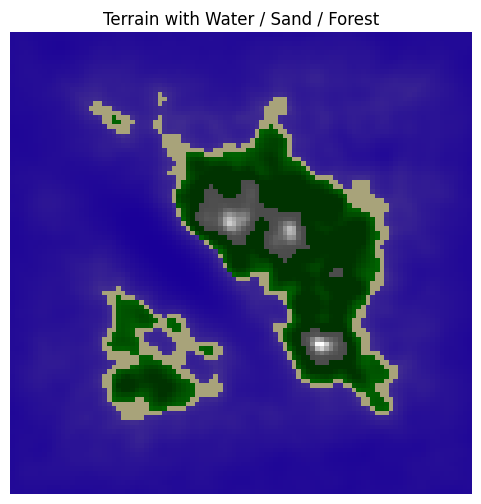

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from perlin_noise import PerlinNoise

np.random.seed(1)
scales = 5
noises = [PerlinNoise(octaves=4 + 2**i, seed=i) for i in range(scales)]
scales_factors = [1.2 ** (-i) for i in range(scales)]
resolution = 100

height = np.zeros((resolution, resolution))

# Generate height map
rift = np.linalg.inv(np.array([[0.5, -0.45], [-0.45, 0.5]]) * 2)
for i in range(resolution):
    for j in range(resolution):
        for noise, scale in zip(noises, scales_factors):
            height[i, j] += (noise([i / resolution, j / resolution]) + 0.5) * scale
        height[i, j] *= min(
            np.exp(-6 * ((0.5 - i / resolution) ** 2)),
            np.exp(-6 * (0.5 - j / resolution) ** 2),
        )
        pos = np.array([i, j]) / resolution - np.array([0.5, 0.34])
        height[i, j] *= 1 - np.exp(-15 * (pos @ rift @ pos))
        # height[i, j] = np.exp(-15 * (pos @ pos))


# Normalize height to [0,1]
height = (height - np.min(height)) / (np.max(height) - np.min(height))

# Define terrain layers
water_level = 0.5
sand_level = water_level + 0.05
mountain_level = 0.8
water = height < water_level
sand = (height >= water_level) & (height < sand_level)
forest = (height >= sand_level) & (height < mountain_level)
mountain = height >= mountain_level

waterness = (1 - (height) / (water_level))[water, None]


sand_color = np.array([0.66, 0.64, 0.48])
deep_water = np.array([0.1, 0.0, 0.6])
shallow_water = deep_water * 0.7 + 0.3 * sand_color

plains_color = np.array([0.0, 0.39, 0.0])
dark_forest_color = np.array([0.0, 0.2, 0.0])
forestness = ((height - sand_level) / (mountain_level - sand_level))[forest, None]

mountain_color = np.array([0.3, 0.3, 0.3])
snow_color = np.array([1.0, 1.0, 1.0])
mountainness = ((height - mountain_level) / (1 - mountain_level))[mountain, None]

forestness = np.minimum(2 * forestness, 1)


# Create an RGB image for visualization
image = np.zeros((resolution, resolution, 3))
image[water] = deep_water * waterness**0.5 + (1 - waterness**0.5) * shallow_water
image[sand] = sand_color  # Sandy color
image[forest] = dark_forest_color * forestness + (1 - forestness) * plains_color
image[mountain] = snow_color * mountainness**4 + (1 - mountainness**4) * mountain_color

# Show the terrain
plt.figure(figsize=(6, 6))
plt.imshow(image, origin="lower")
plt.title("Terrain with Water / Sand / Forest")
plt.axis("off")
plt.show()


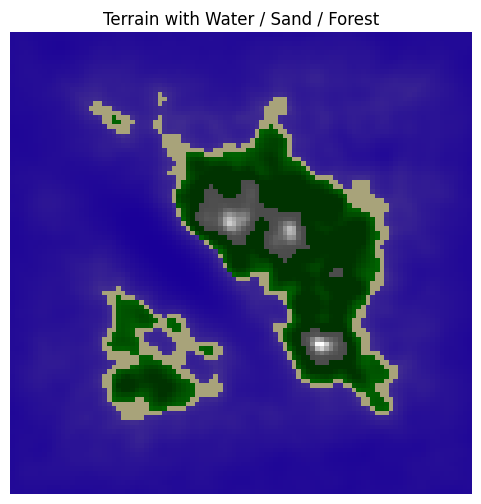

In [49]:
# Show the terrain
plt.figure(figsize=(6, 6))
plt.imshow(image, origin="lower")
plt.title("Terrain with Water / Sand / Forest")
plt.axis("off")

plt.savefig("terrain.png", dpi=200, bbox_inches="tight", pad_inches=0.02)
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt


def downsample_mask(water_mask, factor):
    """
    Downsample a 2D boolean mask by a given factor using simple block averaging.
    If >= 0.5 of the block is True, consider the coarse cell True.
    This helps preserve connectivity of the water region in a coarse sense.
    """
    ny, nx = water_mask.shape
    coarse_ny = ny // factor
    coarse_nx = nx // factor

    # Initialize coarse mask
    coarse_mask = np.zeros((coarse_ny, coarse_nx), dtype=bool)

    for i in range(coarse_ny):
        for j in range(coarse_nx):
            # block boundaries in the fine grid
            i0 = i * factor
            j0 = j * factor
            block = water_mask[i0 : i0 + factor, j0 : j0 + factor]
            # if at least 50% of cells are water, declare coarse cell = water
            if np.mean(block) >= 0.5:
                coarse_mask[i, j] = True

    return coarse_mask


def upsample_array(coarse_array, factor, target_shape):
    """
    Upsample a coarse array to a finer grid by simple nearest-neighbor or bilinear.
    Here we do nearest-neighbor for simplicity.
    target_shape is (ny, nx) of the fine grid.
    """
    coarse_ny, coarse_nx = coarse_array.shape
    fine_ny, fine_nx = target_shape

    fine_array = np.zeros((fine_ny, fine_nx), dtype=coarse_array.dtype)

    for i in range(fine_ny):
        for j in range(fine_nx):
            # Map fine (i, j) to coarse (ic, jc)
            ic = i // factor
            jc = j // factor
            fine_array[i, j] = coarse_array[ic, jc]

    return fine_array


def laplace_pressure_solver(water_mask, init_pressure=None, max_iter=2000, tol=1e-5):
    """
    Solve Laplace's equation ∇^2 p = 0 on the given water_mask using
    Gauss–Seidel relaxation. Dirichlet boundaries:
      - top row water => p=1
      - bottom row water => p=0
    Treat left/right boundaries as Neumann (no-flow) for simplicity.
    """
    ny, nx = water_mask.shape
    if init_pressure is None:
        p = np.zeros((ny, nx), dtype=float)
    else:
        p = init_pressure.copy()

    # Dirichlet boundary conditions:
    # Top boundary -> p=1 where water=True
    for j in range(nx):
        if water_mask[0, j]:
            p[0, j] = 1.0

    # Bottom boundary -> p=0 where water=True
    for j in range(nx):
        if water_mask[ny - 1, j]:
            p[ny - 1, j] = 0.0

    # Gauss–Seidel iteration
    for itr in range(max_iter):
        old_p = p.copy()

        for i in range(1, ny - 1):
            for j in range(0, nx):
                if water_mask[i, j]:
                    # If not a top/bottom Dirichlet row
                    if not (i == 0 or i == ny - 1):
                        # average neighbor pressures (that are water)
                        sum_nb = 0.0
                        count_nb = 0

                        # up
                        if water_mask[i - 1, j]:
                            sum_nb += p[i - 1, j]
                            count_nb += 1

                        # down
                        if water_mask[i + 1, j]:
                            sum_nb += p[i + 1, j]
                            count_nb += 1

                        # left
                        if j <= nx - 2 and j >= 2 and water_mask[i, j - 1]:
                            sum_nb += p[i, j - 1]
                            count_nb += 1

                        # right
                        if j <= nx - 2 and j >= 2 and water_mask[i, j + 1]:
                            sum_nb += p[i, j + 1]
                            count_nb += 1

                        if count_nb > 0:
                            p[i, j] = sum_nb / count_nb

        # check convergence
        diff = np.linalg.norm(p - old_p)
        if diff < tol:
            # print(f"Laplace solver converged in {itr} iterations, diff={diff}")
            break

    return p


def solve_pressure_multiscale(water_mask, num_scales=4, max_iter=1000, tol=1e-5):
    """
    Solve Laplace's equation for the given water_mask in multiple steps:
      1) Solve on a coarsely downsampled grid
      2) Upsample the coarse solution
      3) Refine on a finer grid
      4) Repeat until original resolution
    Returns final pressure at the full resolution.
    """
    ny, nx = water_mask.shape

    # We'll keep track of the solution at the current scale in 'current_pressure'.
    current_pressure = None

    # For s in [0..num_scales-1], we go from coarsest to finest
    for s in range(num_scales):
        # factor by which we downsample:
        #   s=0 => largest factor => coarsest
        #   s=(num_scales-1) => factor=1 => full resolution
        factor = 2 ** (num_scales - 1 - s)

        if factor > 1:
            # Create a coarse mask
            coarse_mask = downsample_mask(water_mask, factor)
            coarse_ny, coarse_nx = coarse_mask.shape

            # If we have a coarse pressure from a previous iteration,
            # downsample it. Otherwise start from zeros.
            if current_pressure is None:
                coarse_pressure = np.zeros((coarse_ny, coarse_nx), dtype=float)
            else:
                # downsample current_pressure
                coarse_pressure = downsample_array(
                    current_pressure, factor, (coarse_ny, coarse_nx)
                )

            # Solve at this coarse scale
            coarse_pressure = laplace_pressure_solver(
                coarse_mask, init_pressure=coarse_pressure, max_iter=max_iter, tol=tol
            )

            # Upsample the coarse solution back to the next scale
            # (which might still be coarser than full resolution, or final)
            next_factor = factor // 2 if factor // 2 >= 1 else 1
            next_shape = (ny // next_factor, nx // next_factor)
            upsampled_pressure = upsample_array(
                coarse_pressure,
                factor=1 if factor == next_factor else (factor // next_factor),
                target_shape=next_shape,
            )

            # This upsampled pressure becomes our "current_pressure"
            current_pressure = upsampled_pressure

        else:
            # factor == 1 means full resolution
            # return current_pressure
            if current_pressure is None:
                # just solve from scratch if we have no prior guess
                current_pressure = laplace_pressure_solver(
                    water_mask, init_pressure=None, max_iter=max_iter, tol=tol
                )
            else:
                # we have an upsampled guess from the previous step
                current_pressure = laplace_pressure_solver(
                    water_mask,
                    init_pressure=current_pressure,
                    max_iter=max_iter,
                    tol=tol,
                )

    # current_pressure should now be the full-resolution solution
    return current_pressure


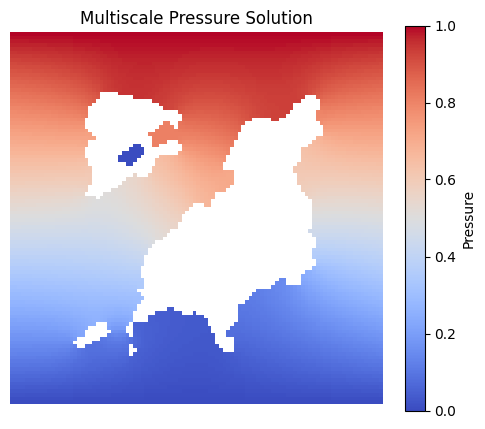

In [50]:
# Suppose we already have a water_mask of shape (ny, nx)

ny, nx = water.shape

# Solve using the multiscale approach
pressure_multiscale = solve_pressure_multiscale(
    water, num_scales=2, max_iter=1000, tol=1e-3
)

# Then we can visualize
plt.figure(figsize=(6, 5))
masked_p = np.ma.array(pressure_multiscale, mask=~water)
plt.imshow(masked_p, cmap="coolwarm", origin="upper")
plt.colorbar(label="Pressure")
plt.title("Multiscale Pressure Solution")
plt.axis("off")
plt.show()


In [40]:
def compute_velocity_field(pressure, water_mask):
    """
    Compute velocity = -grad(p) over the water_mask region.
    We'll return vx, vy with the same shape as pressure.

    Uses forward/backward/central differences depending on which
    neighbors are valid (in water) so we never sample outside water_mask.
    """
    ny, nx = pressure.shape
    vx = np.zeros_like(pressure)
    vy = np.zeros_like(pressure)

    for i in range(ny):
        for j in range(nx):
            if not water_mask[i, j]:
                continue  # no velocity in land cells

            # --- Compute dp/dx ---
            left_ok = (j > 0) and water_mask[i, j - 1]
            right_ok = (j < nx - 1) and water_mask[i, j + 1]

            if left_ok and right_ok:
                # Central difference
                dpdx = 0.5 * (pressure[i, j + 1] - pressure[i, j - 1])
            elif right_ok:
                # Forward difference
                dpdx = pressure[i, j + 1] - pressure[i, j]
            elif left_ok:
                # Backward difference
                dpdx = pressure[i, j] - pressure[i, j - 1]
            else:
                # No valid water neighbors horizontally
                dpdx = 0.0

            # --- Compute dp/dy ---
            up_ok = (i > 0) and water_mask[i - 1, j]
            down_ok = (i < ny - 1) and water_mask[i + 1, j]

            if up_ok and down_ok:
                # Central difference
                dpdy = 0.5 * (pressure[i + 1, j] - pressure[i - 1, j])
            elif down_ok:
                # Forward difference in y
                dpdy = pressure[i + 1, j] - pressure[i, j]
            elif up_ok:
                # Backward difference in y
                dpdy = pressure[i, j] - pressure[i - 1, j]
            else:
                # No valid water neighbors vertically
                dpdy = 0.0

            # Velocity is negative gradient of pressure
            vx[i, j] = dpdx
            vy[i, j] = dpdy

    return vx, vy


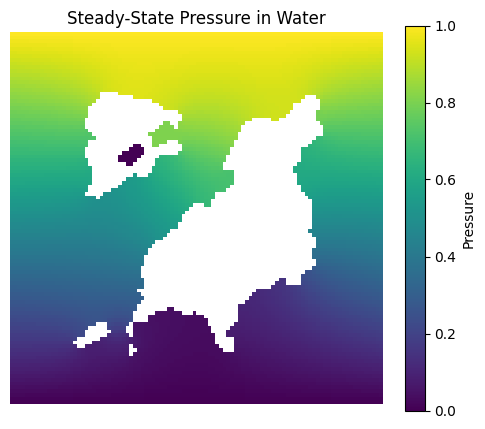

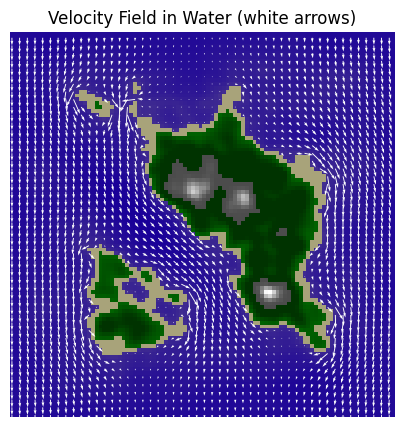

In [51]:
vx, vy = compute_velocity_field(pressure_multiscale, water)
water_velocity = (vx, vy)

# We can visualize the pressure field in water cells:
plt.figure(figsize=(6, 5))
masked_p = np.ma.array(pressure_multiscale, mask=~water)  # mask out non-water
plt.imshow(masked_p, cmap="viridis", origin="upper")
plt.colorbar(label="Pressure")
plt.title("Steady-State Pressure in Water")
plt.axis("off")
plt.show()

# Now let's visualize velocity using quiver
plt.figure(figsize=(6, 5))
plt.imshow(image, origin="lower")  # background: our terrain
# Subsample for clarity, e.g. every 2 or 3 cells
step = 2
y_indices, x_indices = np.mgrid[0:resolution, 0:resolution]

# Only quiver on water cells
q = plt.quiver(
    x_indices[::step, ::step][water[::step, ::step]],
    y_indices[::step, ::step][water[::step, ::step]],
    vx[::step, ::step][water[::step, ::step]],
    vy[::step, ::step][water[::step, ::step]],
    color="white",
    scale=0.005 * resolution,
)

plt.title("Velocity Field in Water (white arrows)")
plt.axis("off")
plt.show()


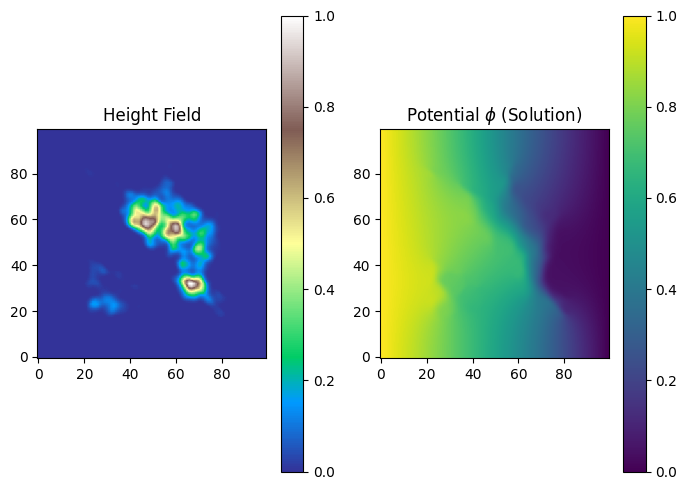

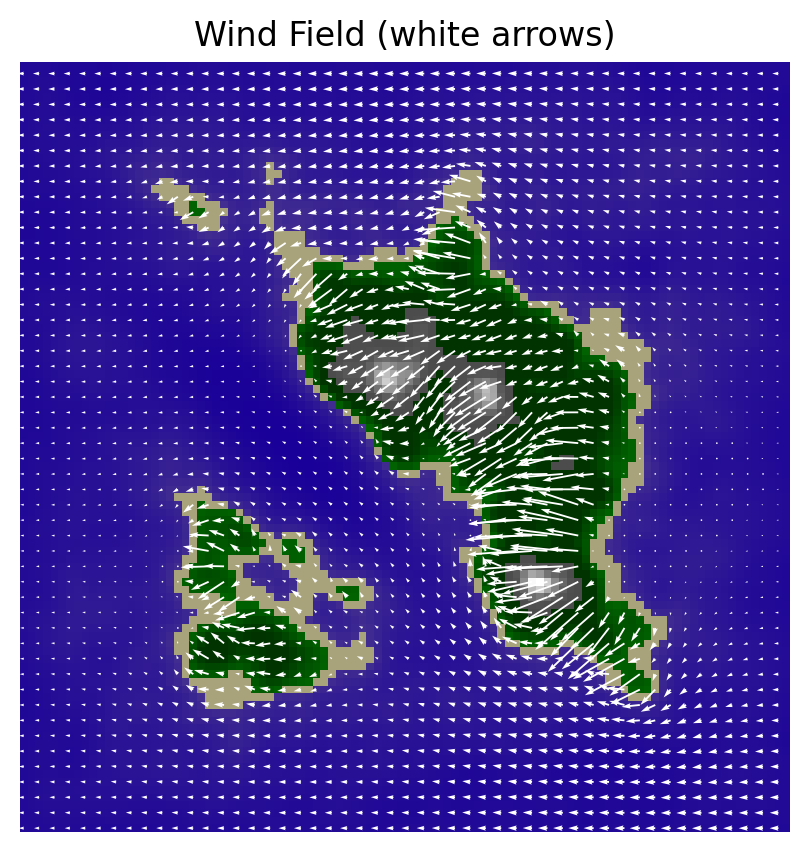

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve


def build_matrix_and_rhs(
    kx, ky, nx, ny, left_val=None, right_val=None, top_val=None, bottom_val=None
):
    """
    Build the sparse matrix A and the RHS vector b for the PDE:
       ∂/∂x [ kx(i+1/2,j) (φ_{i+1,j}-φ_{i,j}) ]
      +∂/∂y [ ky(i,j+1/2) (φ_{i,j+1}-φ_{i,j}) ] = 0,
    with Dirichlet boundary conditions.

    kx, ky are 2D arrays describing face-centered conductivity:
      - kx[i,j] ~ conductivity between (i,j) and (i+1,j)
      - ky[i,j] ~ conductivity between (i,j) and (i,j+1)

    We assume the domain is (ny x nx).

    left_val, right_val, top_val, bottom_val are the (constant) Dirichlet boundary
    values on the left, right, top, and bottom edges.  If any is None, we assume
    that boundary is absent or zero by default.

    Returns: A (in LIL sparse format) and b (1D numpy array).
    """

    N = nx * ny
    A = lil_matrix((N, N), dtype=np.float64)
    b = np.zeros(N, dtype=np.float64)

    def idx(i, j):
        return i * nx + j

    for i in range(ny):
        for j in range(nx):
            row = idx(i, j)

            # Check if (i,j) is on a Dirichlet boundary:
            # Left boundary
            if j == 0 and left_val is not None:
                A[row, row] = 1.0
                b[row] = left_val
                continue
            # Right boundary
            if j == nx - 1 and right_val is not None:
                A[row, row] = 1.0
                b[row] = right_val
                continue
            # Top boundary
            if i == 0 and top_val is not None:
                A[row, row] = 1.0
                b[row] = top_val
                continue
            # Bottom boundary
            if i == ny - 1 and bottom_val is not None:
                A[row, row] = 1.0
                b[row] = bottom_val
                continue

            # Otherwise, this is an interior node or a boundary with no Dirichlet condition:
            # We'll build the 5-point stencil using face-centered conductivities.

            # Coeff for center
            diag_val = 0.0

            # --- left neighbor ---
            if j > 0:
                # average conductivity between (i,j-1) and (i,j)
                kface = kx[i, j - 1]  # stored as conductivity between (i,j-1) and (i,j)
                diag_val += kface
                A[row, idx(i, j - 1)] = -kface

            # --- right neighbor ---
            if j < nx - 1:
                kface = kx[i, j]  # conductivity between (i,j) and (i,j+1)
                diag_val += kface
                A[row, idx(i, j + 1)] = -kface

            # --- up neighbor ---
            if i > 0:
                kface = ky[i - 1, j]  # conductivity between (i-1,j) and (i,j)
                diag_val += kface
                A[row, idx(i - 1, j)] = -kface

            # --- down neighbor ---
            if i < ny - 1:
                kface = ky[i, j]  # conductivity between (i,j) and (i+1,j)
                diag_val += kface
                A[row, idx(i + 1, j)] = -kface

            A[row, row] = diag_val

    return A, b


nx, ny = resolution, resolution
# Let's say we have a "height" array that goes from 0 up to 1
# We'll build it so that it's "higher" near the top row (just as an example).

# We want wind to flow left -> right, so let's define boundary conditions:
left_val = 1.0  # phi=1 at x=0
right_val = 0.0  # phi=0 at x=1
top_val = None  # let's say no Dirichlet (we'll handle it in the interior)
bottom_val = None

surface_height = (
    np.where(height > water_level, (height - water_level) / (1 - water_level), 0) ** 2
)

# Define a conductivity k(x, y) = f(height). For instance:
#   k ~ 1 / (1 + alpha * height)
# so high terrain => smaller k => slower "wind".
alpha = 1000.0
cell_k = 1.0 / (1.0 + alpha * (surface_height))

# We need face-centered k. Let's define:
#   kx[i,j] ~ average conductivity between (i,j) and (i,j+1)
#   ky[i,j] ~ average conductivity between (i,j) and (i+1,j)
kx = np.zeros((ny, nx - 1))
for i in range(ny):
    for j in range(nx - 1):
        kx[i, j] = 0.5 * (cell_k[i, j] + cell_k[i, j + 1])

ky = np.zeros((ny - 1, nx))
for i in range(ny - 1):
    for j in range(nx):
        ky[i, j] = 0.5 * (cell_k[i, j] + cell_k[i + 1, j])

# However, our build_matrix function expects kx and ky to be the same shape as the domain,
# but indexing them as [i, j-1] or [i-1, j] for neighbors.
# Common approach: shift them "inside" a bit. We'll make arrays the same shape (ny x nx),
# but remember that kx[i,j] is the conductivity between (i,j) and (i,j+1).

# Let's pad with zeros to match the dimension (ny, nx).
kx_pad = np.zeros((ny, nx))
kx_pad[:, :-1] = kx  # fill, last column = 0 because there's no neighbor
ky_pad = np.zeros((ny, nx))
ky_pad[:-1, :] = ky  # fill, last row = 0

A, b = build_matrix_and_rhs(
    kx=kx_pad,
    ky=ky_pad,
    nx=nx,
    ny=ny,
    left_val=left_val,
    right_val=right_val,
    top_val=top_val,
    bottom_val=bottom_val,
)

# Convert to CSR/CSC for fast solves
A_csr = A.tocsr()

# Solve A phi = b
phi_vector = spsolve(A_csr, b)

# Reshape back to (ny, nx)
phi = phi_vector.reshape((ny, nx))

# Visualize
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.title("Height Field")
plt.imshow(surface_height, origin="lower", cmap="terrain")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Potential $\phi$ (Solution)")
plt.imshow(phi, origin="lower", cmap="viridis")
plt.colorbar()
plt.tight_layout()
plt.show()

vx, vy = compute_velocity_field(phi, np.ones_like(phi, dtype=bool))
wind_velocity = (vx, vy)

# Now let's visualize velocity using quiver
plt.figure(figsize=(6, 5), dpi=200)
plt.imshow(image, origin="lower")  # background: our terrain
# Subsample for clarity, e.g. every 2 or 3 cells
step = 2
y_indices, x_indices = np.mgrid[0:resolution, 0:resolution]

# Only quiver on water cells
q = plt.quiver(
    x_indices[::step, ::step],
    y_indices[::step, ::step],
    vx[::step, ::step],
    vy[::step, ::step],
    color="white",
    scale=0.01 * resolution,
)

plt.title("Wind Field (white arrows)")
plt.axis("off")
plt.show()


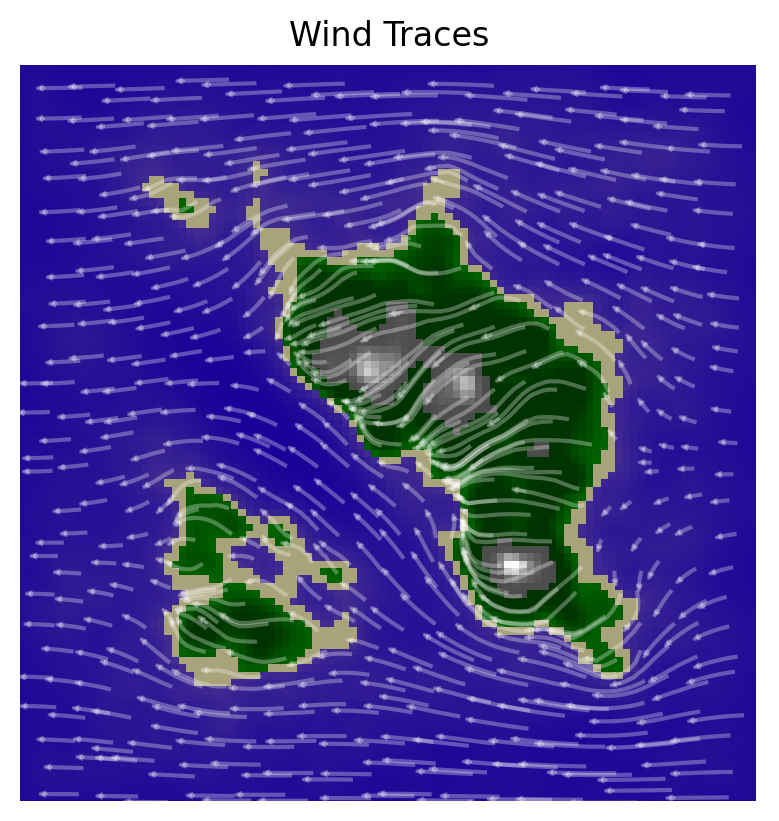

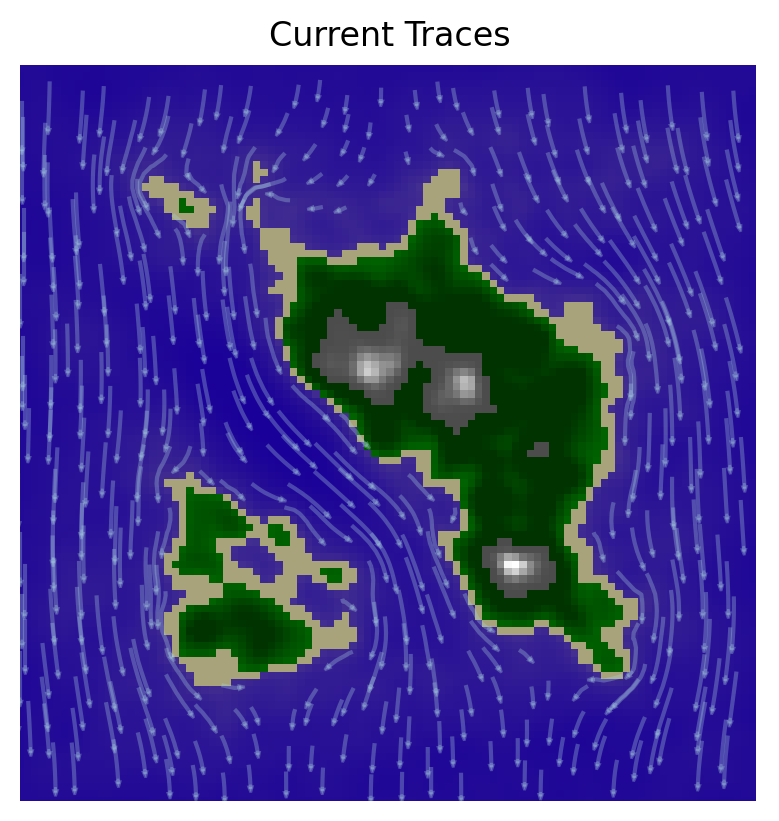

In [53]:
import numpy as np
import matplotlib.pyplot as plt


def trace_streamline(x0, y0, vx, vy, step_size=0.1, max_steps=100):
    """
    vx, vy are 2D arrays of the velocity field on a regular grid.
    (x0, y0) is the seed point in continuous coordinates.
    Returns a list of (x, y) points along the streamline.
    """
    path = [(x0, y0)]
    x, y = x0, y0

    for _ in range(max_steps):
        # Find nearest grid indices
        i = int(y)
        j = int(x)
        if i < 0 or i >= vy.shape[0] - 1 or j < 0 or j >= vx.shape[1] - 1:
            break  # outside domain

        # Velocity at nearest grid cell
        ux = vx[i, j]
        uy = vy[i, j]

        # Update position (Euler)
        x += step_size * ux
        y += step_size * uy

        path.append((x, y))

    return np.array(path)


def get_stream_paths(seed_positions, downsample: int, mask, field, speed_factor: float):
    vx_field, vy_field = field

    xx, yy = (
        np.mgrid[0 : resolution // downsample, 0 : resolution // downsample].astype(
            float
        )
        * downsample
    )

    seed_points = np.stack((xx.ravel(), yy.ravel()), axis=1)
    seed_points += np.random.normal(scale=0.75, size=seed_points.shape)  # jitter
    seed_points = seed_points.tolist()
    seed_points = [p for p in seed_points if mask[int(p[1]), int(p[0])]]  # filter

    paths = []
    i = 0
    while seed_points:
        i += 1
        x0, y0 = seed_points.pop()
        p = trace_streamline(
            x0, y0, vx_field * speed_factor, vy_field * speed_factor, max_steps=30
        )

        crop = 30

        if np.linalg.norm(p[-1] - p[0]) < 0.01 * resolution:
            continue

        if len(p) > crop:
            paths.append(p[: crop - 8])

        if i > 10000:
            print("early break")
            break

    return paths


# Plot
fig = plt.figure(dpi=200)
plt.imshow(image, origin="lower", cmap="gray", alpha=1.0)
arrow_color = "white"
arrow_alpha = 0.3
for p in get_stream_paths(
    seed_positions=None,
    downsample=4,
    mask=np.ones_like(wind_velocity[0], dtype=bool),
    field=wind_velocity,
    speed_factor=300,
):
    p = np.array(p)
    plt.plot(p[:, 0], p[:, 1], color=arrow_color, alpha=arrow_alpha)  # draw streamline
    plt.arrow(
        p[-2, 0],
        p[-2, 1],  # arrow from second-last to last point
        p[-1, 0] - p[-2, 0],
        p[-1, 1] - p[-2, 1],
        shape="full",
        head_width=0.5,
        color=arrow_color,
        alpha=arrow_alpha,
    )
plt.axis("off")

plt.title("Wind Traces")
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.savefig("wind_traces.png", dpi=200, bbox_inches="tight", pad_inches=0.02)
plt.show()

# Plot
plt.figure(dpi=200)
plt.imshow(image, origin="lower", cmap="gray", alpha=1.0)
arrow_color = "lightblue"
arrow_alpha = 0.3
for p in get_stream_paths(
    seed_positions=None,
    downsample=4,
    mask=water,
    field=water_velocity,
    speed_factor=300,
):
    p = np.array(p)
    plt.plot(p[:, 0], p[:, 1], color=arrow_color, alpha=arrow_alpha)  # draw streamline
    plt.arrow(
        p[-2, 0],
        p[-2, 1],  # arrow from second-last to last point
        p[-1, 0] - p[-2, 0],
        p[-1, 1] - p[-2, 1],
        shape="full",
        head_width=0.5,
        # head_length=0.3,
        color=arrow_color,
        alpha=arrow_alpha,
    )
plt.axis("off")

plt.title("Current Traces")
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.savefig("current_traces.png", dpi=200, bbox_inches="tight", pad_inches=0.02)
plt.show()